In [144]:
import pandas as pd
import numpy as np
import re
import string
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag, word_tokenize
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns

In [145]:
# Download NLTK packages
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to D:\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to D:\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to D:\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     D:\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [146]:
# Load Data
df = pd.read_csv("training_data.csv")
df.head()

,TEXT,SENTIMENT
0,poor wifi at food court\nRidiculous,Negative
1,The queue for hours feels like an old-school a...,Negative
2,My recent experience at Kuala Lumpur Internati...,Negative
3,Very slow immigration service at depature and ...,Negative
4,"Gate C is too far away, and the security check...",Negative


In [147]:
#data Cleaning
# Remove rows with missing TEXT
df = df.dropna(subset=['TEXT'])
df = df[df['TEXT'].str.strip() != '']
print(f"After removing missing text: {len(df)}")

After removing missing text: 2587


In [148]:
# Remove clearly mislabeled reviews
def is_mislabeled(text, label):
    """Detect obviously mislabeled reviews"""
    text_lower = str(text).lower()
    
    # Negative label but clearly positive review
    if label == 'Negative':
        positive_phrases = [
            'always impressed', 'smooth check-in', 'efficient security',
            'i love', 'highly recommend', 'absolutely beautiful',
            'perfectly clean', 'excellent service', 'amazing experience'
        ]
        first_100 = text_lower[:100]
        if any(phrase in first_100 for phrase in positive_phrases):
            if not any(word in text_lower for word in ['but', 'however', 'unfortunately', 'worst', 'terrible']):
                return True
    
    # Positive label but clearly negative review  
    if label == 'Positive':
        negative_starts = [
            'worst', 'terrible', 'awful', 'horrible', 'nightmare',
            'disgusting', 'avoid', 'never again', 'do not'
        ]
        first_50 = text_lower[:50]
        if any(phrase in first_50 for phrase in negative_starts):
            if not any(word in text_lower for word in ['not worst', 'not terrible', 'not awful']):
                return True
    
    return False

before_filter = len(df)
df = df[~df.apply(lambda row: is_mislabeled(row['TEXT'], row['SENTIMENT']), axis=1)]
print(f"Removed {before_filter - len(df)} mislabeled reviews")

Removed 2 mislabeled reviews


In [149]:
# Remove reviews that are too short
df['text_length'] = df['TEXT'].str.len()
df = df[df['text_length'] > 20]
df = df.drop('text_length', axis=1)
print(f"After removing short reviews: {len(df)}")

After removing short reviews: 2397


In [150]:
# Handle mixed sentiment reviews
def classify_mixed_sentiment(text):
    """For reviews with both positive and negative words, use majority vote"""
    text_lower = str(text).lower()
    
    strong_negative = ['worst', 'terrible', 'awful', 'horrible', 'nightmare', 'disgusting', 'chaos', 'chaotic']
    strong_positive = ['best', 'excellent', 'amazing', 'wonderful', 'fantastic', 'love', 'perfect']
    
    neg_count = sum(1 for word in strong_negative if word in text_lower)
    pos_count = sum(1 for word in strong_positive if word in text_lower)
    
    if neg_count > 0 and pos_count > 0:
        first_half = text_lower[:len(text_lower)//2]
        neg_first = sum(1 for word in strong_negative if word in first_half)
        pos_first = sum(1 for word in strong_positive if word in first_half)
        
        if neg_first > pos_first:
            return 'Negative'
        elif pos_first > neg_first:
            return 'Positive'
        else:
            return 'Neutral'
    return None

mask = df['SENTIMENT'] == 'Negative'
negative_with_positive = df[mask & df['TEXT'].str.lower().str.contains('best|excellent|amazing|beautiful|wonderful')]

for idx in negative_with_positive.index:
    new_label = classify_mixed_sentiment(df.loc[idx, 'TEXT'])
    if new_label:
        df.loc[idx, 'SENTIMENT'] = new_label

print("\nFinal class distribution:")
print(df['SENTIMENT'].value_counts())


Final class distribution:
SENTIMENT
Negative    1383
Positive     846
Neutral      168
Name: count, dtype: int64


In [151]:
def preprocess(text):
    """Normalize, clean, tokenize, remove stopwords, and lemmatize text."""
    if not isinstance(text, str):
        return ""
    
    text = text.encode('latin1', 'ignore').decode('utf-8', 'ignore')
    text = re.sub(r'\s+', ' ', text).strip()
    text = text.lower()
    
    # Detect comparative statements about OTHER airports
    # Pattern: "send/go to X ... best/excellent" 
    text = re.sub(r'(send|go|fly).{0,100}?(best|excellent|better)\s+(airport|terminal)', 
                  r'COMPARING_TO_BETTER_AIRPORT', text)
    
    # Pattern: "next door/neighbor ... best/excellent"
    text = re.sub(r'(next door|neighbor|neighbouring).{0,60}?(best|excellent|better)', 
                  r'COMPARING_TO_BETTER_AIRPORT', text)
    
    # Mark "run the best" separately (since it's about another airport)
    text = re.sub(r'run.{0,20}?(best|excellent)\s+airport', 
                  r'COMPARING_TO_BETTER_AIRPORT', text)
    
    # Negation handling BEFORE removing punctuation
    text = re.sub(r"\bnot\b\s+(\w+)", r"not_\1", text)
    text = re.sub(r"\bno\b\s+(\w+)", r"no_\1", text)
    
    text = text.translate(str.maketrans("", "", string.punctuation))
    tokens = word_tokenize(text)
    tagged = pos_tag(tokens)
    lemmas = [
        lemmatizer.lemmatize(tok, get_pos(tag))
        for tok, tag in tagged
        if tok not in stop_words
    ]
    
    return " ".join(lemmas)

In [152]:
#Text normalization & cleaning
def normalize_text(text):
    if not isinstance(text, str):
        return ""
    text = text.encode('latin1', 'ignore').decode('utf-8', 'ignore')
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

def clean_text(text):
    text = text.lower()
    return text.translate(str.maketrans("", "", string.punctuation))

df['TEXT'] = df['TEXT'].apply(normalize_text)
df['clean_text'] = df['TEXT'].apply(clean_text)

In [153]:
# Stopwords, airport tag
stop_words = set(stopwords.words('english'))
domain_words = {
    "klia", "airport"
}
stop_words.update(domain_words)

In [154]:
#Negation handling

negation_words = set(["not","no","never","n't","none","nobody","nothing","neither","nor","nowhere","hardly","scarcely","barely"])

def handle_negation(text, window=3):
    tokens = text.split()
    out = []
    i = 0
    while i < len(tokens):
        tok = tokens[i]
        if tok in negation_words:
            out.append(tok)
            for j in range(1, window+1):
                if i+j < len(tokens):
                    out.append(tokens[i+j] + "_NEG")
            i += window + 1
        else:
            out.append(tok)
            i += 1
    return " ".join(out)

In [155]:
#Lemmarization
lemmatizer = WordNetLemmatizer()

def get_pos(tag):
    if tag.startswith('J'): return wordnet.ADJ
    elif tag.startswith('V'): return wordnet.VERB
    elif tag.startswith('N'): return wordnet.NOUN
    elif tag.startswith('R'): return wordnet.ADV
    else: return wordnet.NOUN

def lemmatize_text(text):
    words = word_tokenize(text)
    pos_tags = pos_tag(words)
    return " ".join([
        lemmatizer.lemmatize(word, get_pos(tag))
        for word, tag in pos_tags
        if word not in stop_words
    ])

In [ ]:
df['processed_text'] = df['TEXT'].apply(lemmatize_text)
df.head()

,TEXT,SENTIMENT,clean_text,processed_text
0,poor wifi at food court Ridiculous,Negative,poor wifi at food court ridiculous,poor wifi food court ridiculous
1,The queue for hours feels like an old-school a...,Negative,the queue for hours feels like an oldschool ai...,queue hour feel like oldschool
2,My recent experience at Kuala Lumpur Internati...,Negative,my recent experience at kuala lumpur internati...,recent experience kuala lumpur international n...
3,Very slow immigration service at depature and ...,Negative,very slow immigration service at depature and ...,slow immigration service depature arrival time...
4,"Gate C is too far away, and the security check...",Negative,gate c is too far away and the security check ...,gate c far away security check front gate shor...


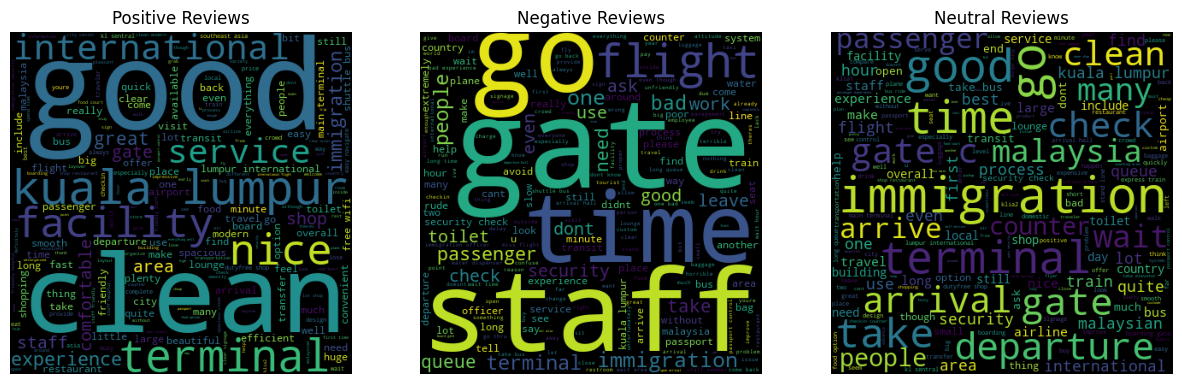

In [157]:
# WordClouds
positive_text = " ".join(df[df.SENTIMENT=="Positive"]['processed_text'])
negative_text = " ".join(df[df.SENTIMENT=="Negative"]['processed_text'])
neutral_text  = " ".join(df[df.SENTIMENT=="Neutral"]['processed_text'])

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.title("Positive Reviews")
plt.imshow(WordCloud(width=400, height=400).generate(positive_text))
plt.axis('off')

plt.subplot(1,3,2)
plt.title("Negative Reviews")
plt.imshow(WordCloud(width=400, height=400).generate(negative_text))
plt.axis('off')

plt.subplot(1,3,3)
plt.title("Neutral Reviews")
plt.imshow(WordCloud(width=400, height=400).generate(neutral_text))
plt.axis('off')
plt.show()

In [158]:
# Save cleaned data
df[['TEXT', 'processed_text','SENTIMENT']].to_csv("cleaned_training_data.csv", index=False)
print("Saved cleaned_training_data.csv")

Saved cleaned_training_data.csv
